<a href="https://colab.research.google.com/github/blancavazquez/CursoDatosMasivosII/blob/2023-I/notebooks/4d_casoNetflix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sistema de recomendación: caso Netflix

Objetivo: construir un sistema de recomendación de películas basado en los datos de Netflix.

Los pasos a seguir son:
* Análisis de datos
* Pre-procesamiento
* Construcción del sistema de recomendación
    - Usando filtrado colaborativo

[Fuente de datos](https://www.kaggle.com/code/laowingkin/netflix-movie-recommendation/data)

In [ ]:
"""Carga de bibliotecas"""
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikit-surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""Carga de la base de datos"""
#selección de ID y rating
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/combined_data_1.txt', 
                 header = None, names = ['User_Id', 'Rating'], usecols = [0,1])
df['Rating'] = df['Rating'].astype(float)
print("Tamaño original:", df.shape)

Tamaño original: (24058263, 2)


In [ ]:
df_raiting = df[:500000] #selección de sub-conjunto de registros
df_raiting.tail(10)

,User_Id,Rating
499990,2284938,3.0
499991,996626,4.0
499992,1778262,1.0
499993,1823668,2.0
499994,1129025,4.0
499995,1957556,4.0
499996,1492198,3.0
499997,1018901,3.0
499998,213704,4.0
499999,2143870,3.0


In [ ]:
print('Tamaño de la base de datos: {}'.format(df_raiting.shape))

Tamaño de la base de datos: (500000, 2)


## Análisis de datos

In [ ]:
print("Conteo de raitings")
p = df_raiting.groupby('Rating')['Rating'].agg(['count'])
print(p)

Conteo de raitings
         count
Rating        
1.0      25316
2.0      52325
3.0     147151
4.0     174248
5.0     100812


In [ ]:
movie_count = df_raiting.isnull().sum()[1]#Se obtiene el total de películas
users_count = df_raiting['User_Id'].nunique() - movie_count#Se obtiene el total de usuarios
rating_count = df_raiting['User_Id'].count() - movie_count#Se obtiene el total de ratings

print("Total de películas:", movie_count, "total de usuarios:", users_count, "total de ratings:", rating_count)

Total de películas: 148 total de usuarios: 214992 total de ratings: 499852


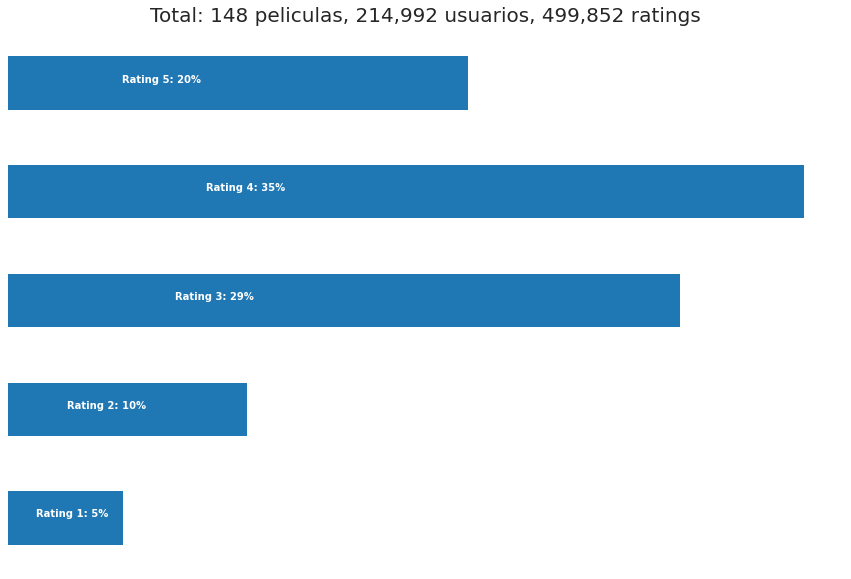

In [ ]:
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total: {:,} peliculas, {:,} usuarios, {:,} ratings'.format(movie_count, users_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

Se observa que la mayoría de los ratings tiende a ser positiva (>3)

## Carga del catálogo de películas

In [ ]:
"""Carga de la base de datos de películas"""
df_movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/movie_titles.csv', 
                        encoding = "ISO-8859-1", header = None, 
                        names = ['Movie_Id', 'Year', 'Name'])
df_movies.set_index('Movie_Id', inplace = True)
print (df_movies.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


## Construcción del sistema de recomendación usando filtrado colaborativo

Construye un sistema de recomendació, usando filtrado colaborativo.

Tip: puedes usar la biblioteca [Surprise](https://surprise.readthedocs.io/en/stable/getting_started.html) y emplear el algoritmo de [factorización de matrices probabilísticas](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD).